In [1]:
# === SETUP: Run this first! ===
import os
import sys

# Change to project root and add to Python path
notebook_dir = os.getcwd()
project_root = os.path.dirname(notebook_dir)  # Goes up one level from 'notebooks/'
os.chdir(project_root)
sys.path.insert(0, project_root)

print(f"Project root: {project_root}")
print(f"tsnn module path: {os.path.join(project_root, 'tsnn')}")

Project root: /Users/gremy/Code/TSNN-1
tsnn module path: /Users/gremy/Code/TSNN-1/tsnn


# Transformer architecture tests

In [2]:
# In this notebook we will test out different architectures of the transformer and see how they perform at different levels of noise.

In [3]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
import torch
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
import importlib
import sys
sys.path.append('/Users/cyrilgarcia/notebooks/tsnn/')

import tsnn

from tsnn.generators import generators
from tsnn.benchmarks import benchmark_comparison, ml_benchmarks, torch_benchmarks
from tsnn import utils
import torch.nn.functional as F
import math
from typing import Optional


plt.style.use('ggplot')

In [4]:
from dataclasses import dataclass

@dataclass
class Config:
    T: int = 3000
    n_ts: int = 50
    n_f: int = 10
    pct_zero_corr: float = 0.5
    split_conditional: float = 0.
    split_shift: float = 0.0
    split_seasonal: float = 0.
    split_cs: float = 0.0
    split_cs_shift: float = 1.0
    low_corr: float = 0.1
    high_corr: float = 0.2

In [5]:
z = generators.Generator(Config.T, Config.n_ts, Config.n_f)

In [6]:
%%time
z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)

CPU times: user 38.1 ms, sys: 9.03 ms, total: 47.1 ms
Wall time: 43.9 ms


In [7]:
#z.get_dataloader()

In [8]:
from torch import nn
device = 'mps'

# Current transformer model

In [9]:
# Currently we are using the following transformer in the wide setting.

In [10]:
z.get_dataloader(n_rolling=10)

In [11]:
# For references the shapes of train batches.

In [12]:
batch1 = next(iter(z.train))
print(batch1[0].shape)
print(batch1[1].shape)

torch.Size([256, 10, 50, 10])
torch.Size([256, 50])


In [13]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, d_model=128, nhead=8, num_layers=2, dropout=0.8):
        super().__init__()
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        # pass through Transformer encoder
        causal_mask = torch.triu(torch.ones(n_rolling, n_rolling, device=x.device), diagonal=1).bool()
        encoded = self.encoder(x, mask=causal_mask)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

In [14]:
m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████| 200/200 [00:45<00:00,  4.38it/s]


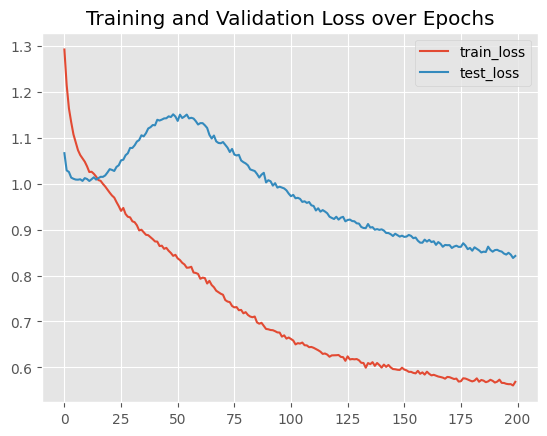

In [15]:
model_torch.fit(z.train, test=z.test, epochs=200)

In [16]:
#comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm, model_torch], model_names=['lasso', 'lr', 'lstm', 'transformer'])
comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['transformer'])

In [17]:
comp.correl(z, mode='train')

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


,true,optimal,cs_shift
optimal,0.3313,nan,nan
cs_shift,0.3313,1.0000,nan
transformer,0.7718,0.3026,0.3026


In [18]:
comp.correl(z, mode='test')

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


,true,optimal,cs_shift
optimal,0.3236,nan,nan
cs_shift,0.3236,1.0000,nan
transformer,0.4702,0.2367,0.2367


# Varying noise level and architecture

## Varying noise and dropout

In [63]:
# Let's first vary the noise and dropout parameter and see what the results look like.

In [64]:
class Config:
    T: int = 3000
    n_ts: int = 50
    n_f: int = 10
    pct_zero_corr: float = 0.5
    split_conditional: float = 0.
    split_shift: float = 0.0
    split_seasonal: float = 0.
    split_cs: float = 0.0
    split_cs_shift: float = 1.0
    low_corr: float = 0.1
    high_corr: float = 0.2

In [65]:
#noise_level_low = [0.01, 0.05, 0.1]
#noise_level_high = [0.02, 0.1, 0.2]

noise_level_low = [0.02, 0.05, 0.1, 0.2]
noise_level_high = [0.05, 0.1, 0.2, 0.5]

In [66]:
dic_z = {}

for i in range(len(noise_level_low)):
    #z = generators.Generator(1000, 100, 10)
    z = generators.Generator(Config.T, Config.n_ts, Config.n_f)
    # z.generate_dataset(pct_zero_corr = 0.5,
    #                       split_conditional = 0.,
    #                       split_shift = 1.0,
    #                       split_seasonal = 0.,
    #                       low_corr=noise_level_low[i], high_corr=noise_level_high[i])
    z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=noise_level_low[i], 
                  high_corr=noise_level_high[i])
    
    z.get_dataloader(n_rolling=10)
    
    #z.get_dataloader(n_rolling=5, narrow=True, train_test_split=True, shuffle=False)
    name_z = "z" + str(i)
    dic_z[name_z] = z
    

In [67]:
dic_z

{'z0': <tsnn.generators.generators.Generator at 0x178237d90>,
 'z1': <tsnn.generators.generators.Generator at 0x17827dc90>,
 'z2': <tsnn.generators.generators.Generator at 0x17970e790>,
 'z3': <tsnn.generators.generators.Generator at 0x1782e3810>}

In [68]:
# Next let's give ourselves a sequence of models, say the transformer where we modify one parameter.

In [69]:
dropout_values = [0, 0.25, 0.5, 0.8, 0.85, 0.9]

In [70]:
dic_models = {}

for i in range(len(dropout_values)):
    m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, dropout=dropout_values[i]).to(device)
    #m = TransformerEncoderModel(10, 5).to(device)
    model_name = "model" + str(i)
    dic_models[model_name] = m  


In [71]:
dic_models.keys()

dict_keys(['model0', 'model1', 'model2', 'model3', 'model4', 'model5'])

In [72]:
# Let's now compute the performance of all the models.

In [ ]:
dropout_correls_IS = np.zeros((len(noise_level_low), len(dropout_values)))
dropout_correls_OOS = np.zeros((len(noise_level_low), len(dropout_values)))

In [ ]:
#Let's now run the above on all the indexes and see what we get

for index1 in range(len(noise_level_low)):
    for index2 in range(len(dropout_values)):

        name_z = "z" + str(index1)
        model_name = "model" + str(index2)
        
        z = dic_z[name_z]
        m = dic_models[model_name]
        
        optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
        model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
        model_torch.fit(z.train, test=z.test, epochs=200)
        
        comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
        out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
        out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]

        dropout_correls_IS[index1][index2] = out_train
        dropout_correls_OOS[index1][index2] = out_test

        print(model_name, name_z, " done")



In [75]:
pd_dropout_correls_IS = pd.DataFrame(dropout_correls_IS, index=["min_correl_" + str(x) for x in noise_level_low],
                             columns=["dropout_" + str(x) for x in dropout_values])
pd_dropout_correls_OOS = pd.DataFrame(dropout_correls_OOS, index=["min_correl_" + str(x) for x in noise_level_low],
                             columns=["dropout_" + str(x) for x in dropout_values])

In [76]:
print("Correlation IS between transformer prediction and optimal y for different levels of correl and different values of dropout.")
pd_dropout_correls_IS.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=4)

Correlation IS between transformer prediction and optimal y for different levels of correl and different values of dropout.


,dropout_0,dropout_0.25,dropout_0.5,dropout_0.8,dropout_0.85,dropout_0.9
min_correl_0.02,0.0869,0.0854,0.0816,0.0589,0.0450,-0.0005
min_correl_0.05,0.1809,0.1771,0.1687,0.1258,0.1105,0.0071
min_correl_0.1,0.3287,0.3239,0.3118,0.2804,0.2373,0.0085
min_correl_0.2,0.5986,0.5949,0.5831,0.5236,0.4895,0.0138


In [77]:
pd_dropout_correls_OOS.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=4)

,dropout_0,dropout_0.25,dropout_0.5,dropout_0.8,dropout_0.85,dropout_0.9
min_correl_0.02,-0.0017,0.0019,-0.0033,0.0007,-0.0050,-0.0020
min_correl_0.05,0.0166,0.0071,0.0022,0.0012,0.0033,0.0085
min_correl_0.1,0.0374,0.0361,0.0684,0.1634,0.0891,0.0025
min_correl_0.2,0.0700,0.3303,0.4640,0.4406,0.3624,-0.0013


In [78]:
# Clearly here we see that high dropout greatly increases the correlation when there is a lot of noise.

## Adding the weight decay

In [19]:
# In the above since we are struggling to get a good prediciton in the presence of noise, let's try to add the weight decay.

In [20]:
class Config:
    T: int = 3000
    n_ts: int = 50
    n_f: int = 10
    pct_zero_corr: float = 0.5
    split_conditional: float = 0.
    split_shift: float = 0.0
    split_seasonal: float = 0.
    split_cs: float = 0.0
    split_cs_shift: float = 1.0
    low_corr: float = 0.1
    high_corr: float = 0.2

In [21]:
#noise_level_low = [0.01, 0.05, 0.1]
#noise_level_high = [0.02, 0.1, 0.2]

noise_level_low = [0.02, 0.05, 0.1, 0.2]
noise_level_high = [0.05, 0.1, 0.2, 0.5]

In [22]:
dic_z = {}

for i in range(len(noise_level_low)):
    #z = generators.Generator(1000, 100, 10)
    z = generators.Generator(Config.T, Config.n_ts, Config.n_f)
    # z.generate_dataset(pct_zero_corr = 0.5,
    #                       split_conditional = 0.,
    #                       split_shift = 1.0,
    #                       split_seasonal = 0.,
    #                       low_corr=noise_level_low[i], high_corr=noise_level_high[i])
    z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=noise_level_low[i], 
                  high_corr=noise_level_high[i])
    
    z.get_dataloader(n_rolling=10)
    
    #z.get_dataloader(n_rolling=5, narrow=True, train_test_split=True, shuffle=False)
    name_z = "z" + str(i)
    dic_z[name_z] = z
    

In [23]:
dic_z

{'z0': <tsnn.generators.generators.Generator at 0x30eebc450>,
 'z1': <tsnn.generators.generators.Generator at 0x30ec3ec50>,
 'z2': <tsnn.generators.generators.Generator at 0x30eed2e50>,
 'z3': <tsnn.generators.generators.Generator at 0x30eed1890>}

In [24]:
# Next let's give ourselves a sequence of models, say the transformer where we modify one parameter.

In [25]:
# Let's now compute the performance of all the models.

In [40]:
#weidecay_values = [1e-4, 1e-3, 1e-2]
weidecay_values = [0.01, 0.1, 1]

In [41]:
weidecay_values

[0.01, 0.1, 1]

In [28]:
weidecay_correls_IS = np.zeros((len(noise_level_low), len(weidecay_values) +1))
weidecay_correls_OOS = np.zeros((len(noise_level_low), len(weidecay_values) +1))

In [39]:
weidecay_correls_OOS.shape

(4, 4)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:46<00:00,  4.33it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


model0 z0  done


100%|██████████| 200/200 [00:46<00:00,  4.29it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


model0 z1  done


100%|██████████| 200/200 [00:46<00:00,  4.29it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


model0 z2  done


100%|██████████| 200/200 [00:45<00:00,  4.40it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


model0 z3  done


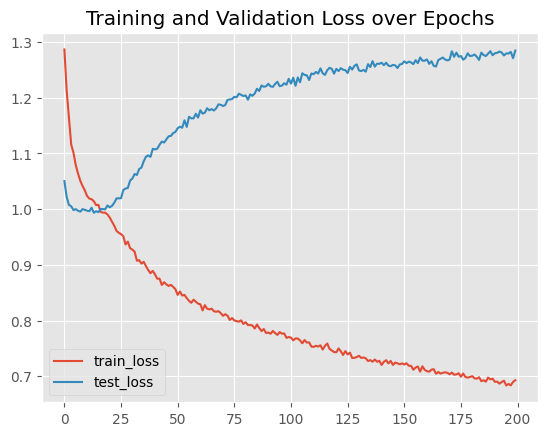

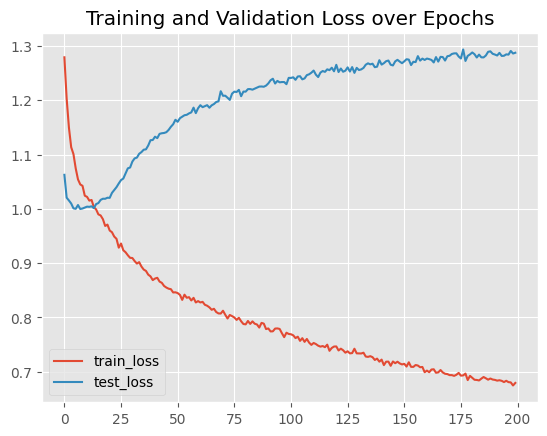

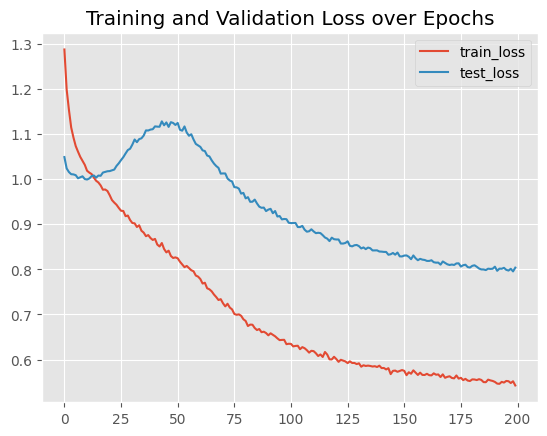

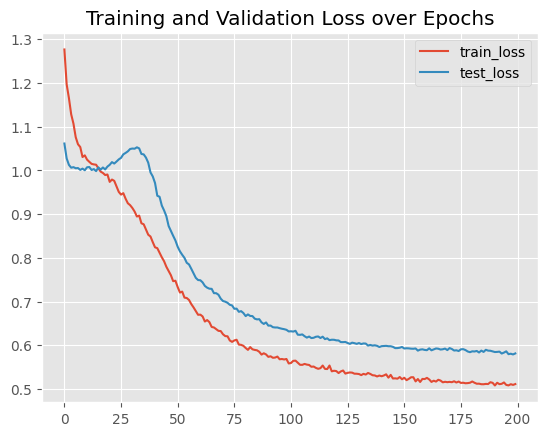

In [30]:
# Let's now run the above on all the indexes and see what we get

for index1 in range(len(noise_level_low)):
    index2 = 0 
    
    name_z = "z" + str(index1)
    model_name = "model" + str(index2)
    
    z = dic_z[name_z]
    m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10).to(device)
    optimizer = torch.optim.AdamW(
        m.parameters(),
        lr=0.001,
    )
    
    model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
    model_torch.fit(z.train, test=z.test, epochs=200)
    
    comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
    
    out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
    out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]

    weidecay_correls_IS[index1][index2] = out_train
    weidecay_correls_OOS[index1][index2] = out_test

    print(model_name, name_z, " done")

In [ ]:

for index1 in range(len(noise_level_low)):
    for index2 in range(1, len(weidecay_values) +1):

        name_z = "z" + str(index1)
        model_name = "model" + str(index2)
        
        z = dic_z[name_z]
        m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10).to(device)
        optimizer = torch.optim.AdamW(
            m.parameters(),
            lr=0.001,
            weight_decay=weidecay_values[index2 - 1]   # ← Recommended for noisy time-series
        )
        model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
        model_torch.fit(z.train, test=z.test, epochs=200)
        
        comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
        out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
        out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]

        weidecay_correls_IS[index1][index2] = out_train
        weidecay_correls_OOS[index1][index2] = out_test

        print(model_name, name_z, " done")



In [43]:
pd_weidecay_correls_IS = pd.DataFrame(weidecay_correls_IS, index=["min_correl_" + str(x) for x in noise_level_low],
                             columns=["weidecay_" + str(x) for x in [0] + weidecay_values])

pd_weidecay_correls_OOS = pd.DataFrame(weidecay_correls_OOS, index=["min_correl_" + str(x) for x in noise_level_low],
                             columns=["weidecay_" + str(x) for x in [0] + weidecay_values])


In [44]:
print("Correlation IS between transformer prediction and optimal y for different levels of correl and different values of weight decay.")
pd_weidecay_correls_IS.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=4)

Correlation IS between transformer prediction and optimal y for different levels of correl and different values of weight decay.


,weidecay_0,weidecay_0.01,weidecay_0.1,weidecay_1
min_correl_0.02,0.0497,0.0477,0.0474,0.0463
min_correl_0.05,0.1201,0.1164,0.1229,0.1324
min_correl_0.1,0.3397,0.3410,0.3412,0.3387
min_correl_0.2,0.5040,0.5035,0.5041,0.4979


In [45]:
pd_weidecay_correls_OOS.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=4)

,weidecay_0,weidecay_0.01,weidecay_0.1,weidecay_1
min_correl_0.02,0.0030,0.0009,0.0015,0.0022
min_correl_0.05,0.0182,0.0112,0.0186,0.0387
min_correl_0.1,0.2799,0.2807,0.2810,0.2827
min_correl_0.2,0.4485,0.4446,0.4464,0.4425


In [46]:
# This does not look great.. does it make sense to add even more weight decay??

## Varying dmodel

In [19]:
# Does it help to vary the dmodel dimension in the higher noise setting ??

In [20]:
noise_level_low = [0.02, 0.05, 0.1, 0.2]
noise_level_high = [0.05, 0.1, 0.2, 0.5]

In [21]:
dic_z = {}

for i in range(len(noise_level_low)):
    #z = generators.Generator(1000, 100, 10)
    z = generators.Generator(Config.T, Config.n_ts, Config.n_f)
    # z.generate_dataset(pct_zero_corr = 0.5,
    #                       split_conditional = 0.,
    #                       split_shift = 1.0,
    #                       split_seasonal = 0.,
    #                       low_corr=noise_level_low[i], high_corr=noise_level_high[i])
    z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=noise_level_low[i], 
                  high_corr=noise_level_high[i])
    
    z.get_dataloader(n_rolling=10)
    
    #z.get_dataloader(n_rolling=5, narrow=True, train_test_split=True, shuffle=False)
    name_z = "z" + str(i)
    dic_z[name_z] = z
    

In [22]:
dic_z

{'z0': <tsnn.generators.generators.Generator at 0x31c2b1590>,
 'z1': <tsnn.generators.generators.Generator at 0x31c21f490>,
 'z2': <tsnn.generators.generators.Generator at 0x31c4771d0>,
 'z3': <tsnn.generators.generators.Generator at 0x31c477490>}

In [23]:
d_model_values = [8, 16, 32, 64, 128]

In [24]:
dic_models = {}

for i in range(len(d_model_values)):
    m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, d_model=d_model_values[i]).to(device)
    #m = TransformerEncoderModel(10, 5).to(device)
    model_name = "model" + str(i)
    dic_models[model_name] = m  


In [25]:
dic_models.keys()

dict_keys(['model0', 'model1', 'model2', 'model3', 'model4'])

In [26]:
correls_IS = np.zeros((len(noise_level_low), len(d_model_values)))
correls_OOS = np.zeros((len(noise_level_low), len(d_model_values)))

In [ ]:
# Let's now run the above on all the indexes and see what we get

for index1 in range(len(noise_level_low)):
    for index2 in range(len(d_model_values)):

        name_z = "z" + str(index1)
        model_name = "model" + str(index2)
        
        z = dic_z[name_z]
        m = dic_models[model_name]
        
        optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
        model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
        model_torch.fit(z.train, test=z.test, epochs=200)
        
        comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
        out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
        out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]

        correls_IS[index1][index2] = out_train
        correls_OOS[index1][index2] = out_test

        print(model_name, name_z, " done")



In [31]:
pd_correls_IS = pd.DataFrame(correls_IS, index=["min_correl_" + str(x) for x in noise_level_low],
                             columns=["d_model_" + str(x) for x in d_model_values])
pd_correls_OOS = pd.DataFrame(correls_OOS, index=["min_correl_" + str(x) for x in noise_level_low],
                            columns=["d_model_" + str(x) for x in d_model_values])

In [32]:
print("Correlation IS between transformer prediction and optimal y for different levels of correl and different values of d_model.")
pd_correls_IS.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=4)

Correlation IS between transformer prediction and optimal y for different levels of correl and different values of d_model.


,d_model_8,d_model_16,d_model_32,d_model_64,d_model_128
min_correl_0.02,0.0228,0.0324,0.0360,0.0444,0.0490
min_correl_0.05,0.0555,0.0682,0.0823,0.1012,0.1135
min_correl_0.1,0.1093,0.1363,0.1624,0.2350,0.2806
min_correl_0.2,0.1998,0.2686,0.3360,0.4640,0.5464


In [33]:
pd_correls_OOS.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=4)

,d_model_8,d_model_16,d_model_32,d_model_64,d_model_128
min_correl_0.02,-0.0000,0.0056,0.0081,0.0128,0.0137
min_correl_0.05,-0.0028,0.0060,0.0013,0.0068,0.0096
min_correl_0.1,-0.0091,-0.0103,-0.0037,0.0999,0.1667
min_correl_0.2,0.0067,0.0026,0.0282,0.3138,0.4812


In [34]:
# Larger d_model seems to be better but we are still not making progress at high level of noise.

## Varying the number of heads

In [32]:
# Does it help to vary the dmodel dimension in the higher noise setting ??

In [33]:
noise_level_low = [0.02, 0.05, 0.1, 0.2]
noise_level_high = [0.05, 0.1, 0.2, 0.5]

In [34]:
dic_z = {}

for i in range(len(noise_level_low)):
    #z = generators.Generator(1000, 100, 10)
    z = generators.Generator(Config.T, Config.n_ts, Config.n_f)
    # z.generate_dataset(pct_zero_corr = 0.5,
    #                       split_conditional = 0.,
    #                       split_shift = 1.0,
    #                       split_seasonal = 0.,
    #                       low_corr=noise_level_low[i], high_corr=noise_level_high[i])
    z.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=noise_level_low[i], 
                  high_corr=noise_level_high[i])
    
    z.get_dataloader(n_rolling=10)
    
    #z.get_dataloader(n_rolling=5, narrow=True, train_test_split=True, shuffle=False)
    name_z = "z" + str(i)
    dic_z[name_z] = z
    

In [35]:
dic_z

{'z0': <tsnn.generators.generators.Generator at 0x31cca0210>,
 'z1': <tsnn.generators.generators.Generator at 0x31b0a50d0>,
 'z2': <tsnn.generators.generators.Generator at 0x31cc776d0>,
 'z3': <tsnn.generators.generators.Generator at 0x31b060390>}

In [36]:
nhead_values = [4,8,16,32]

In [37]:
dic_models = {}

for i in range(len(nhead_values)):
    m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, nhead=nhead_values[i]).to(device)
    #m = TransformerEncoderModel(10, 5).to(device)
    model_name = "model" + str(i)
    dic_models[model_name] = m  


In [38]:
dic_models.keys()

dict_keys(['model0', 'model1', 'model2', 'model3'])

In [39]:
heads_correls_IS = np.zeros((len(noise_level_low), len(nhead_values)))
heads_correls_OOS = np.zeros((len(noise_level_low), len(nhead_values)))

In [ ]:
# Let's now run the above on all the indexes and see what we get

for index1 in range(len(noise_level_low)):
    for index2 in range(len(nhead_values)):

        name_z = "z" + str(index1)
        model_name = "model" + str(index2)
        
        z = dic_z[name_z]
        m = dic_models[model_name]
        
        optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
        model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
        model_torch.fit(z.train, test=z.test, epochs=200)
        
        comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
        out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
        out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]

        heads_correls_IS[index1][index2] = out_train
        heads_correls_OOS[index1][index2] = out_test

        print(model_name, name_z, " done")



In [41]:
pd_heads_correls_IS = pd.DataFrame(heads_correls_IS, index=["min_correl_" + str(x) for x in noise_level_low],
                             columns=["nhead_" + str(x) for x in nhead_values])
pd_heads_correls_OOS = pd.DataFrame(heads_correls_OOS, index=["min_correl_" + str(x) for x in noise_level_low],
                             columns=["nhead_" + str(x) for x in nhead_values])

In [42]:
print("Correlation IS between transformer prediction and optimal y for different levels of correl and different values of nhead.")
pd_heads_correls_IS.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=4)

Correlation IS between transformer prediction and optimal y for different levels of correl and different values of nhead.


,nhead_4,nhead_8,nhead_16,nhead_32
min_correl_0.02,0.0552,0.0597,0.0591,0.0602
min_correl_0.05,0.0984,0.1039,0.1049,0.1086
min_correl_0.1,0.2337,0.2747,0.2677,0.2616
min_correl_0.2,0.5847,0.5807,0.5547,0.5508


In [43]:
pd_heads_correls_OOS.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=4)

,nhead_4,nhead_8,nhead_16,nhead_32
min_correl_0.02,0.0049,0.0091,0.0043,0.0042
min_correl_0.05,0.0078,0.0124,0.0141,0.0156
min_correl_0.1,0.0700,0.1449,0.1372,0.1228
min_correl_0.2,0.5019,0.5304,0.4770,0.4531


In [44]:
# Here it seems that nhead=4 is the best choice, which is what we had chosen, this is good!